# IMUIF Samna

This implementation will feed the input from the PC and make it possible to read the output of IMUIF module.
Since it's not directly possible to read the output of IMUIF module, we'll implement a dummy network that will return whatever we feed it.

In [3]:
import numpy as np

from rockpool.devices.xylo.imu.preprocessing.imuif_samna import IMUIFSamna
from rockpool.devices.xylo.imu.preprocessing.quantizer import Quantizer
from rockpool.timeseries import TSEvent

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12


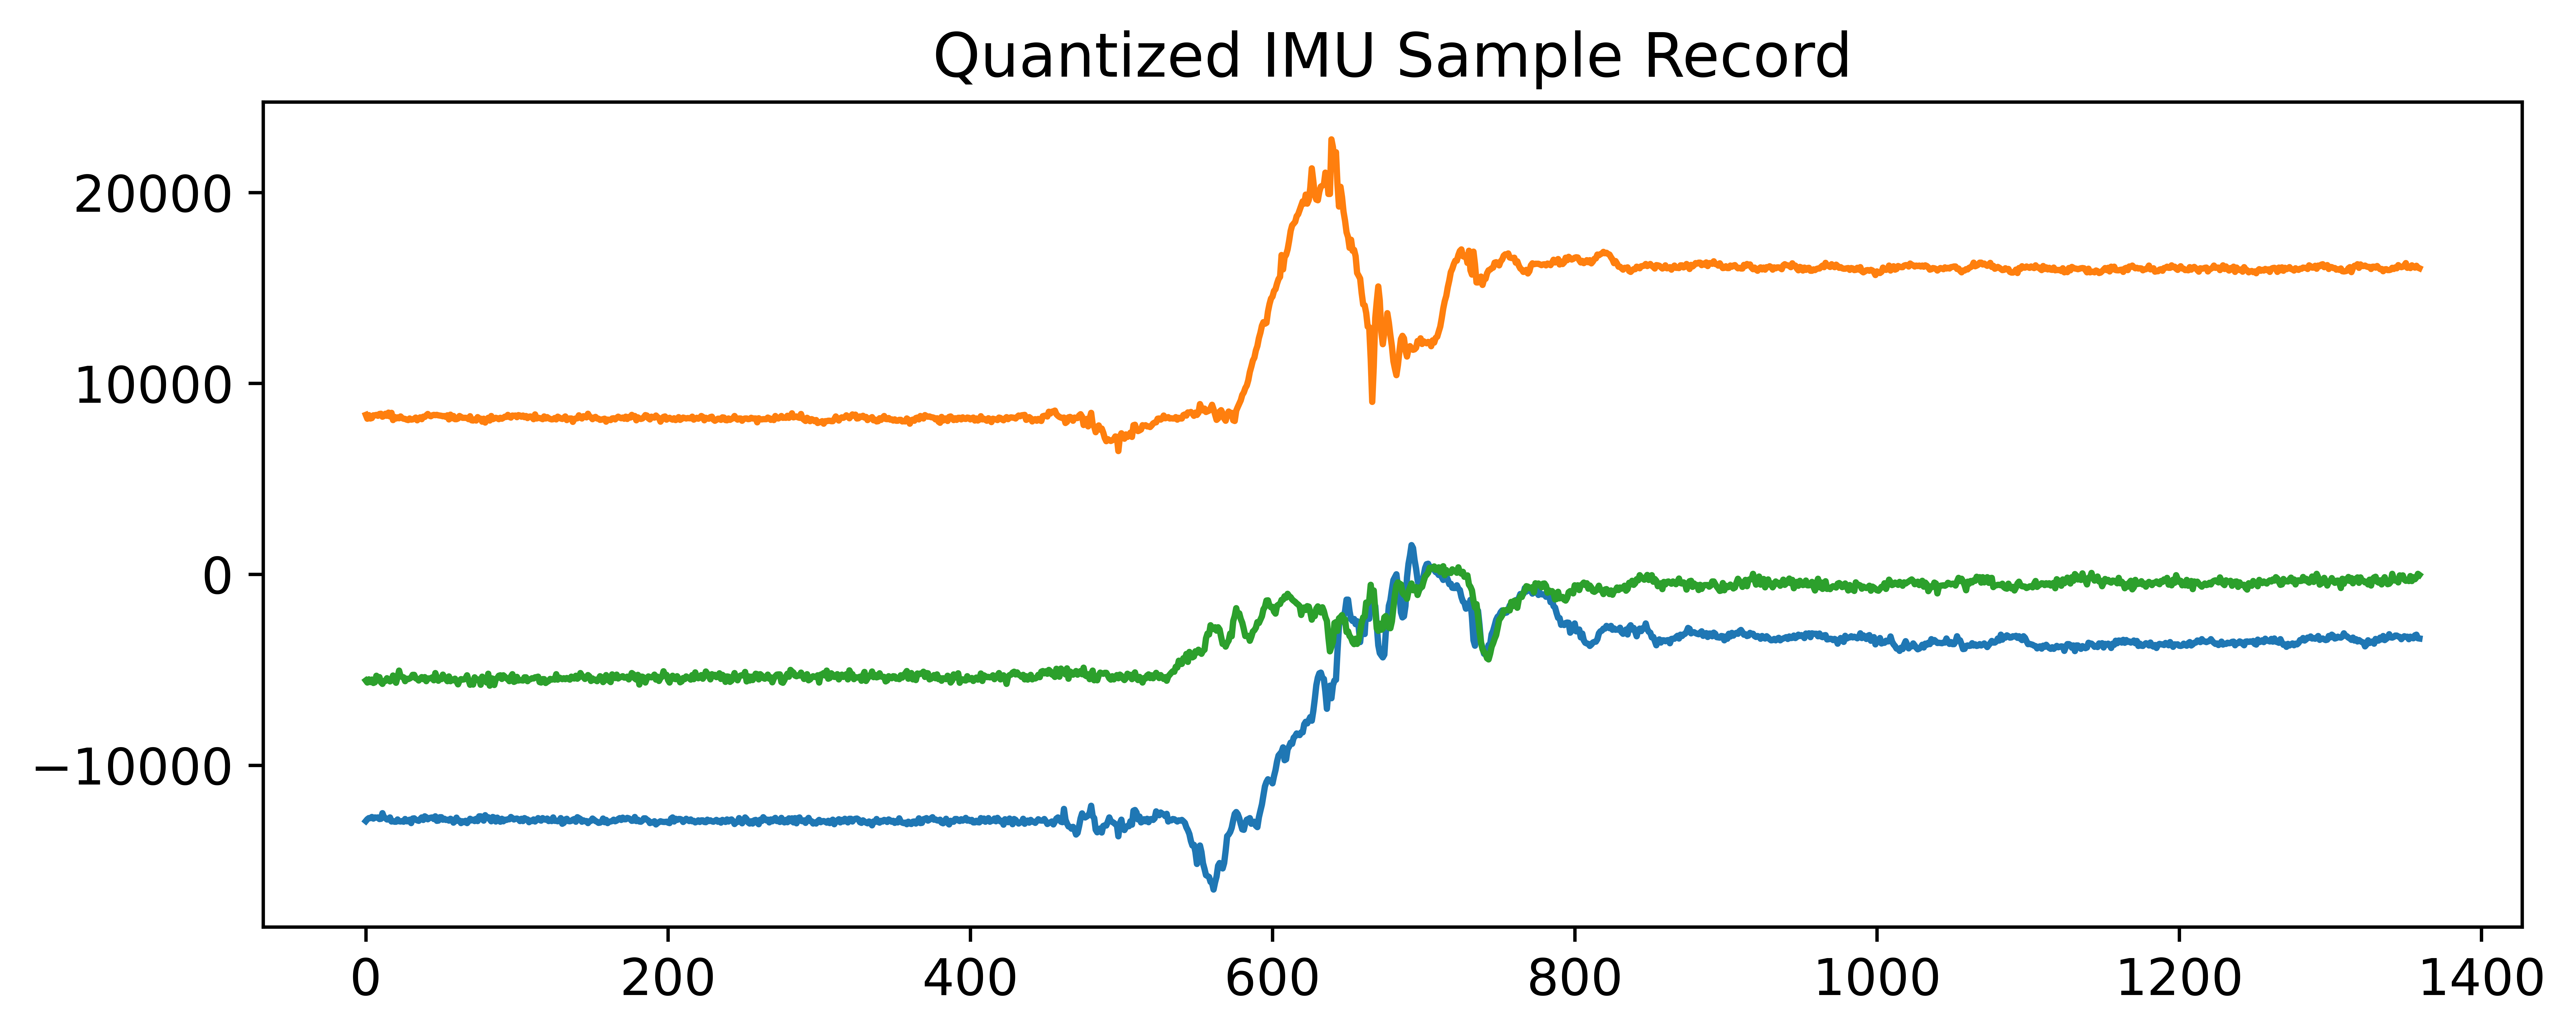

In [4]:
## Step 1 : Quantize the data
with open("data.npy", "rb") as f:
    data = np.load(f)
    
quantizer = Quantizer(scale=0.49, num_bits=16)

data_quantized, _, _ = quantizer(data)
data_quantized.shape

plt.figure()
plt.plot(data_quantized[0])
plt.title(f"Quantized IMU Sample Record")
plt.show()

In [5]:
from rockpool.devices.xylo.imu import xylo_imu_devkit_utils as putils

# - Find and connect to a Xylo IMU HDK
xylo_hdk_nodes = putils.find_xylo_imu_boards()
print(xylo_hdk_nodes)

if len(xylo_hdk_nodes) == 0:
    assert False, 'This tutorial requires a connected Xylo IMU HDK to demonstrate.'
else:
    db = xylo_hdk_nodes[0]

In [6]:
mod = IMUIFSamna(device=db, interface_params={"select_iaf_output":True}, prerecorded_imu_input=True)

WARNING    /home/ugurcan/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/imu/preprocessing/lookup.py:59: RuntimeWarning: divide by zero encountered in divide
  self.cot2_vals = 1 / np.tan(2 * self.angles_radian)
 [py.warnings]
  self.cot2_vals = 1 / np.tan(2 * self.angles_radian)



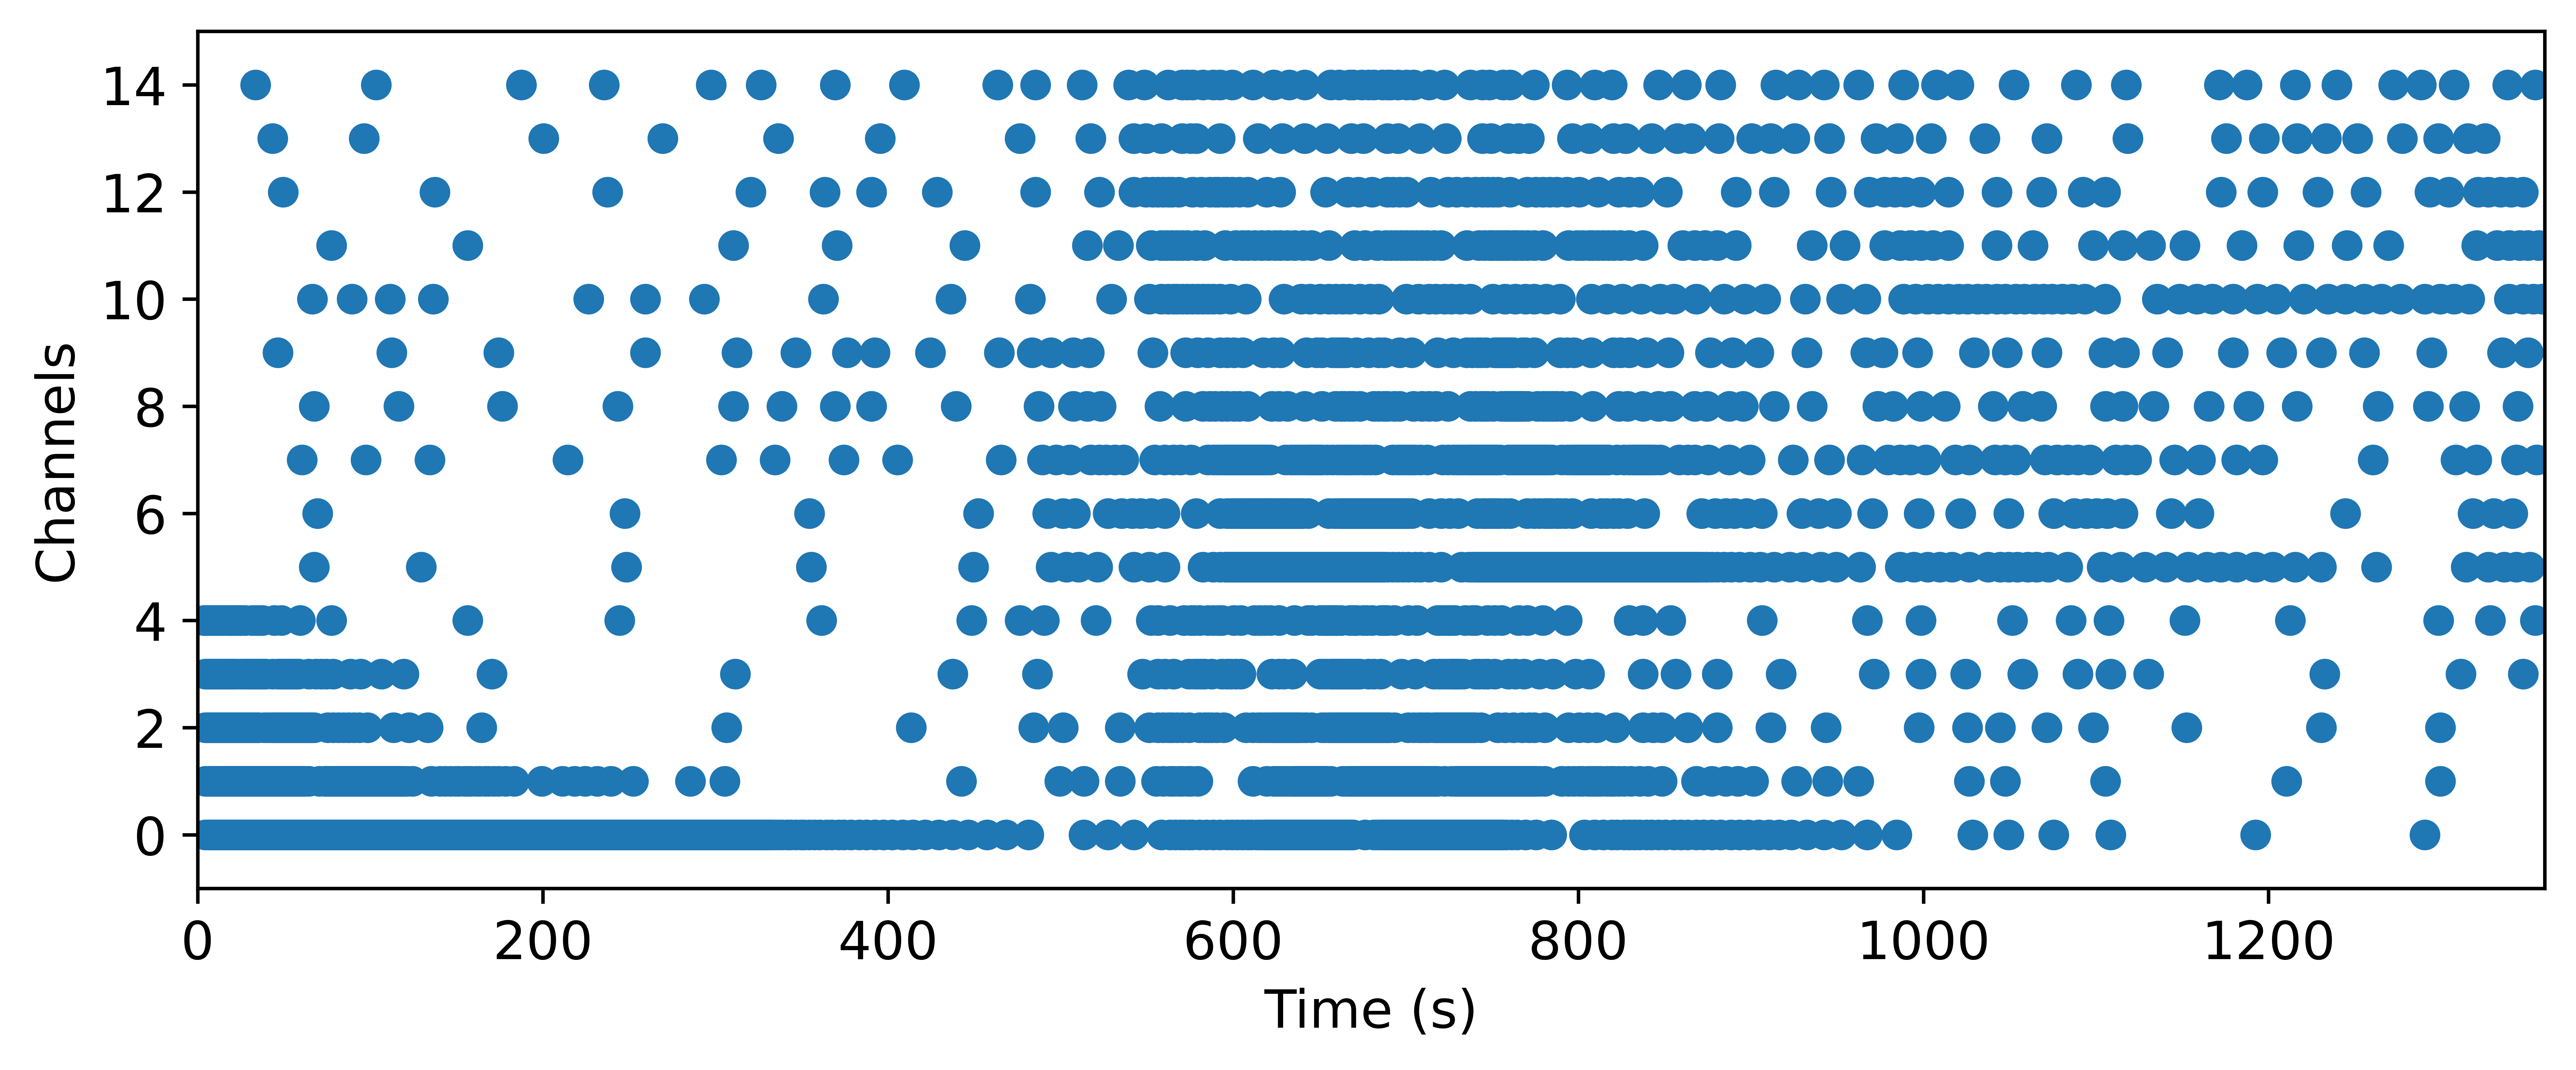

In [7]:
spike_out, state, record_dict = mod.evolve(data_quantized, record=True)
TSEvent.from_raster(spike_out).plot()